In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import h5py

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from collections import OrderedDict

sns.set_style("white")

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

C:\Users\ameyv\anaconda3\envs\amey-pinn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Multi-Layer-Perceptron(MLP) architecture for our Physics Informed Neural Network(PINN)
class MLP(torch.nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        out = self.layers(xy)
        return out

In [17]:
# Class for the actual PINN containing training and other details
class PINN():
    def __init__(self, X_bc, Y_bc, S_bc, X, Y, layers, xmin, xmax, ymin, ymax, Re):

        # Boundary Conditions (Domain Boundaries)
        self.xmin = torch.tensor(xmin).float().to(device)
        self.xmax = torch.tensor(xmax).float().to(device)
        self.ymin = torch.tensor(ymin).float().to(device)
        self.ymax = torch.tensor(ymax).float().to(device)

        # Boundary Data (Dirichlet Boundary Conditions)
        self.X_bc = torch.tensor(X_bc).float().to(device)
        self.Y_bc = torch.tensor(Y_bc).float().to(device)
        self.S_bc = torch.tensor(S_bc).float().to(device)
        
        # Training Data (Colocation Points)
        self.X = torch.tensor(X, requires_grad=True).float().to(device)
        self.Y = torch.tensor(Y, requires_grad=True).float().to(device)
        
        # PINN Hyperparameters
        self.layers = layers
        self.nu = 1/Re
        self.mlp = MLP(layers).to(device)
        
        # Optimizer (Adam)
        self.optimizer = torch.optim.Adam(self.mlp.parameters(), lr=0.1)
        self.epochs = 500
        self.iter = 0
    
    def pdeLoss(self, x, y):
        s = self.mlp(x, y)
        #u = torch.reshape(s[:,0], (s.shape[0], 1))
        #v = torch.reshape(s[:,1], (s.shape[0], 1))
        #p = torch.reshape(s[:,2], (s.shape[0], 1))
        # print("u: ", u.shape)
        # print("u: ", type(u))
        # print("x: ", x.shape)
        # print("x: ", type(x))

        u = s[:,0]
        v = s[:,1]
        p = s[:,2]
        
        du_dy = torch.autograd.grad(inputs=y, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        dv_dy = torch.autograd.grad(inputs=y, outputs=v, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        dp_dy = torch.autograd.grad(inputs=y, outputs=p, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        
        du_dx = torch.autograd.grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        dv_dx = torch.autograd.grad(inputs=x, outputs=v, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        dp_dx = torch.autograd.grad(inputs=x, outputs=p, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        
        du_dxx = torch.autograd.grad(inputs=x, outputs=du_dx, grad_outputs=torch.ones_like(du_dx), retain_graph=True, create_graph=True)[0]
        du_dyy = torch.autograd.grad(inputs=y, outputs=du_dy, grad_outputs=torch.ones_like(du_dy), retain_graph=True, create_graph=True)[0]
        dv_dxx = torch.autograd.grad(inputs=x, outputs=dv_dx, grad_outputs=torch.ones_like(dv_dx), retain_graph=True, create_graph=True)[0]
        dv_dyy = torch.autograd.grad(inputs=y, outputs=dv_dy, grad_outputs=torch.ones_like(dv_dy), retain_graph=True, create_graph=True)[0]
        
        # du_dx, du_dy = torch.autograd.grad(u, (x, y), create_graph=True)
        # dv_dx, dv_dy = torch.autograd.grad(v, (x, y), create_graph=True)
        # dp_dx, dp_dy = torch.autograd.grad(p, (x, y), create_graph=True)

        # du_dxx, du_dxy = torch.autograd.grad(du_dx[0], (x, y))
        # du_dyx, du_dyy = torch.autograd.grad(du_dy[1], (x, y))
        # dv_dxx, dv_dxy = torch.autograd.grad(dv_dx[0], (x, y))
        # dv_dyx, dv_dyy = torch.autograd.grad(dv_dy[1], (x, y))

        f1 = u.squeeze() * du_dx + v.squeeze() * du_dy + dp_dx - self.nu * (du_dxx + du_dyy)
        f2 = u.squeeze() * dv_dx + v.squeeze() * dv_dy + dp_dy - self.nu * (dv_dxx + dv_dyy)
        f3 = du_dx + dv_dy
        f = f1 + f2 + f3
        return f
    
    def lossFunc(self):
        Solutions = self.mlp(self.X_bc, self.Y_bc)
        Residuals = self.pdeLoss(self.X, self.Y)
        # print("Solutions:", type(Solutions))
        # print("Residuals:", type(Residuals))
        Data_loss = torch.mean((self.S_bc - Solutions) ** 2)
        Physics_loss = torch.mean(Residuals ** 2)
        loss = Data_loss + Physics_loss
        self.iter += 1
        if self.iter % 25 == 0:
            print('Iter %d, Loss: %.4e, Loss_u: %.4e, Loss_f: %.4e' % (self.iter, loss.item(), Data_loss.item(), Physics_loss.item()))
        return loss
    
    def train(self):
        self.mlp.train()
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss = self.lossFunc()
            loss.backward()
            self.optimizer.step()
            
            
    def predict(self, X, Y): 
        x = torch.tensor(X, requires_grad=True).float().to(device)
        y = torch.tensor(Y, requires_grad=True).float().to(device)

        self.mlp.eval()
        s = self.mlp(x, y)
        f = self.pdeLoss(x, y)
        return s, f

In [23]:
# Train the model
layers = [2, 20, 20, 20, 20, 20, 20, 3]
xmin = 0.5
xmax = 1
ymin = 0.5
ymax = 1.5
Re = 20
N = 50

f = h5py.File('data\colocation_points.h5', 'r')
X = f['X']
Y = f['Y']
X = np.asarray(X)
Y = np.asarray(Y)
print("X:", X.shape)
print("Y:", Y.shape)

f_bc = h5py.File('data\dirichlet_boundary_points.h5', 'r')
X_bc = f_bc['X_bc']
Y_bc = f_bc['Y_bc']
X_bc = np.asarray(X_bc)
Y_bc = np.asarray(Y_bc)
S_bc = np.zeros((4*N,3))

nu = 1 / Re
lamb = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)
U_bc = 1-(np.exp(lamb*X_bc))*(np.cos(2*math.pi*Y_bc))
V_bc = (lamb/(2*math.pi))*(np.exp(lamb*X_bc))*(np.sin(2*math.pi*Y_bc))
P_bc = (1/2)*(1-(np.exp(2*lamb*X_bc)))
S_bc = np.hstack((U_bc,V_bc,P_bc))
print("X_bc:", X_bc.shape)
print("Y_bc:", Y_bc.shape)
print("S_bc:", S_bc.shape)

X: (2500, 1)
Y: (2500, 1)
X_bc: (200, 1)
Y_bc: (200, 1)
S_bc: (200, 3)


In [24]:
model = PINN(X_bc, Y_bc, S_bc, X, Y, layers, xmin, xmax, ymin, ymax, Re)
model.train()

Iter 25, Loss: 9.73271e-01, Loss_u: 9.73271e-01, Loss_f: 1.08497e-10
Iter 50, Loss: 9.73982e-01, Loss_u: 9.73982e-01, Loss_f: 5.96667e-11
Iter 75, Loss: 9.71502e-01, Loss_u: 9.71502e-01, Loss_f: 2.83666e-09
Iter 100, Loss: 1.00713e+00, Loss_u: 1.00713e+00, Loss_f: 2.21785e-07
Iter 125, Loss: 9.73298e-01, Loss_u: 9.73289e-01, Loss_f: 8.33136e-06
Iter 150, Loss: 9.69737e-01, Loss_u: 9.68417e-01, Loss_f: 1.31955e-03
Iter 175, Loss: 9.72323e-01, Loss_u: 9.72323e-01, Loss_f: 7.23941e-10
Iter 200, Loss: 9.71615e-01, Loss_u: 9.71615e-01, Loss_f: 1.00116e-10
Iter 225, Loss: 9.71377e-01, Loss_u: 9.71377e-01, Loss_f: 8.60522e-11
Iter 250, Loss: 9.71348e-01, Loss_u: 9.71348e-01, Loss_f: 8.14018e-11
Iter 275, Loss: 9.71346e-01, Loss_u: 9.71346e-01, Loss_f: 7.63568e-11
Iter 300, Loss: 9.71346e-01, Loss_u: 9.71346e-01, Loss_f: 7.20579e-11
Iter 325, Loss: 9.71346e-01, Loss_u: 9.71346e-01, Loss_f: 6.79133e-11
Iter 350, Loss: 9.71346e-01, Loss_u: 9.71346e-01, Loss_f: 6.40388e-11
Iter 375, Loss: 9.71346

In [25]:
f = h5py.File('data\Analytical_Solutions\Re_20.h5', 'r')
#f.visit(printname)
U = f['U']
V = f['V']
P = f['P']
U = np.asarray(U)
V = np.asarray(V)
P = np.asarray(P)
U = torch.from_numpy(U)
V = torch.from_numpy(V)
P = torch.from_numpy(P)
print("U: ", U.shape)
print("V: ", V.shape)
print("P: ", P.shape)
f.close()

s_test = torch.hstack((U,V,P))
s_pred, f_pred = model.predict(X, Y)
print("Predicted Solutions: ", s_pred.shape)
print("Analytical Solutions: ", s_test.shape)

# Relative L2 Error
error_s = torch.linalg.norm(s_test-s_pred,2)/torch.linalg.norm(s_test,2)
print('Relative L2 Error: %e' % (error_s))

U:  torch.Size([2500, 1])
V:  torch.Size([2500, 1])
P:  torch.Size([2500, 1])
Predicted Solutions:  torch.Size([2500, 3])
Analytical Solutions:  torch.Size([2500, 3])
Relative L2 Error: 7.957665e-01


In [26]:
u_test = torch.reshape(U, (N,N))
v_test = torch.reshape(V, (N,N))
p_test = torch.reshape(P, (N,N))
u_pred = torch.reshape(s_pred[:,0], (N,N)).detach().numpy()
v_pred = torch.reshape(s_pred[:,1], (N,N)).detach().numpy()
p_pred = torch.reshape(s_pred[:,2], (N,N)).detach().numpy()

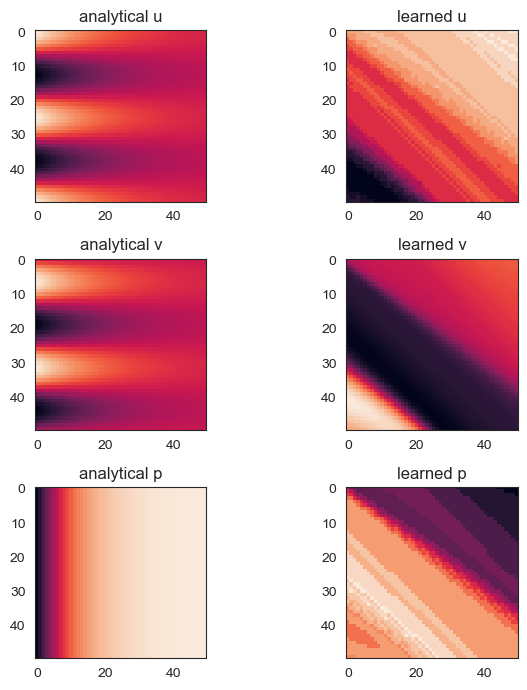

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))
axs[0, 0].imshow(u_test)
axs[0, 0].set_title('analytical u')
axs[1, 0].imshow(v_test)
axs[1, 0].set_title('analytical v')
axs[2, 0].imshow(p_test)
axs[2, 0].set_title('analytical p')
axs[0, 1].imshow(u_pred)
axs[0, 1].set_title('learned u')
axs[1, 1].imshow(v_pred)
axs[1, 1].set_title('learned v')
axs[2, 1].imshow(p_pred)
axs[2, 1].set_title('learned p')
fig.tight_layout()

In [ ]:
params = model.mlp.state_dict()
print(params.keys())
print(type(params['layers.layer_0.weight']))
print(params['layers.layer_0.weight'].shape)
flattened_tensor = torch.reshape(params['layers.layer_0.weight'], (-1,))
print(type(flattened_tensor))
print(flattened_tensor.shape)

In [ ]:
flattened_weights = []
for key in params.keys():
    flattened_tensor = torch.reshape(params[key], (-1,)).tolist()
#     print(len(flattened_tensor))
    for val in flattened_tensor:
        flattened_weights.append(val)
# print(type(flattened_weights))
# print(len(flattened_weights))
# print(flattened_weights)
weights_array = np.array(flattened_weights)
np.savetxt('data/weights/weights_'+str(Re)+'.txt', weights_array)